# Moj rad

In [2]:
from __future__ import print_function
#import potrebnih biblioteka
import cv2
import collections

# keras
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD
from keras.models import model_from_json

#Sklearn biblioteka sa implementiranim K-means algoritmom
from sklearn import datasets
from sklearn.cluster import KMeans

%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = 160, 141 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno

from pocetak import *
from services.preparation_for_neural_network import *
from services.show_result import *
from debug_helper.helper import *

In [3]:
image_path0 = 'dataset/train/alphabet1.png'
letters0 = load_image_and_find_roi_HSV_TRAIN(image_path0)
alphabet0 = ['A', 'B', 'C', 'Č', 'Ć', 'D', 'E', 'F', 'G', 'H','I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S','Š', 'T', 'U','V', 'W', 'X', 'Y', 'Z', 'Ž']

image_path1 = 'dataset/train/alphabet1.png'
letters1 = load_image_and_find_roi_HSV_TRAIN(image_path1)
alphabet1 = ['a', 'b', 'c', 'č', 'ć', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
            'n', 'o', 'p', 'q',
            'r', 's', 'š', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ž']
alphabet= alphabet0 + alphabet1
letters = letters0 + letters1

inputs = prepare_for_ann(letters)
outputs = convert_output(alphabet)
print("duzina inputa: " + str(len(inputs)))
print("duzina outputs: " + str(len(outputs)))

# probaj da ucitas prethodno istreniran model
ann = load_trained_ann()

# ako je ann=None, znaci da model nije ucitan u prethodnoj metodi i da je potrebno istrenirati novu mrezu
if ann is None:
    print("Traniranje modela zapoceto.")
    ann = create_ann()
    ann = train_ann(ann, inputs, outputs)
    print("Treniranje modela zavrseno.")
    # serijalizuj novu mrezu nakon treniranja, da se ne trenira ponovo svaki put
    serialize_ann(ann)

duzina inputa: 60
duzina outputs: 60
Istrenirani model uspesno ucitan.


In [ ]:
# Učitavanje slike i određivanje regiona od interesa
validation_image_path = 'dataset/train/alphabet1.png'
distances, letters = load_image_and_find_roi_HSV_validate(validation_image_path)

In [ ]:
# PREDIKCIJA
print(extract_text(distances, letters, ann,vocabulary))

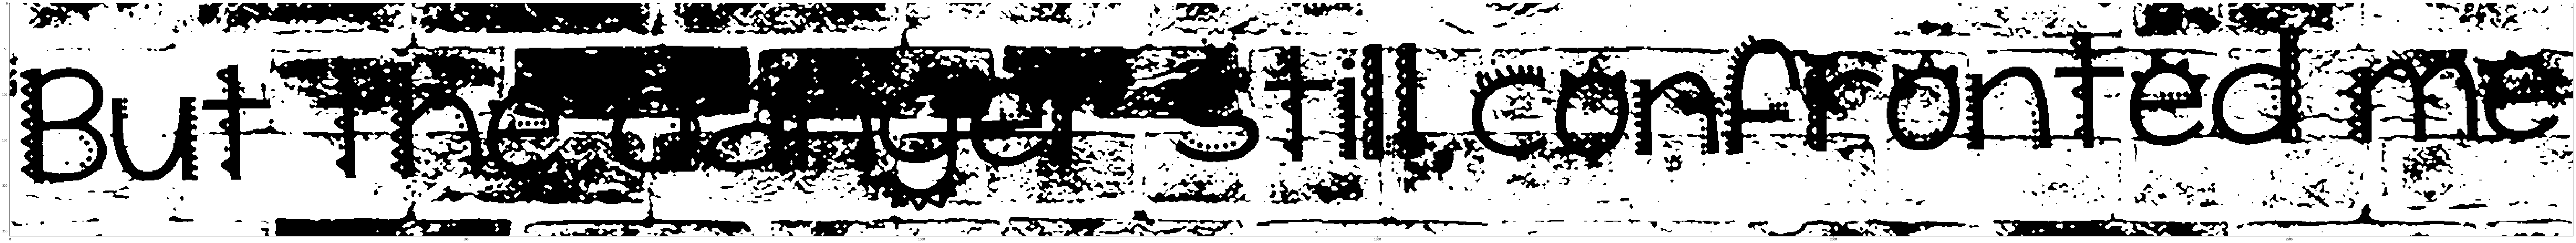

In [4]:
# POPRAVLJANJEEEE SEGMENTACIJE
image_path = 'dataset/validation/train86.png'
image, img, opening = image_segmentation(image_path,1)
plt.imshow(opening,'gray')

In [5]:
percentWhitePixel = get_percents_for_white_and_black_pixels(img, opening)
print("procenat belih: " + str(percentWhitePixel))

procenat belih: 64.53536184210526


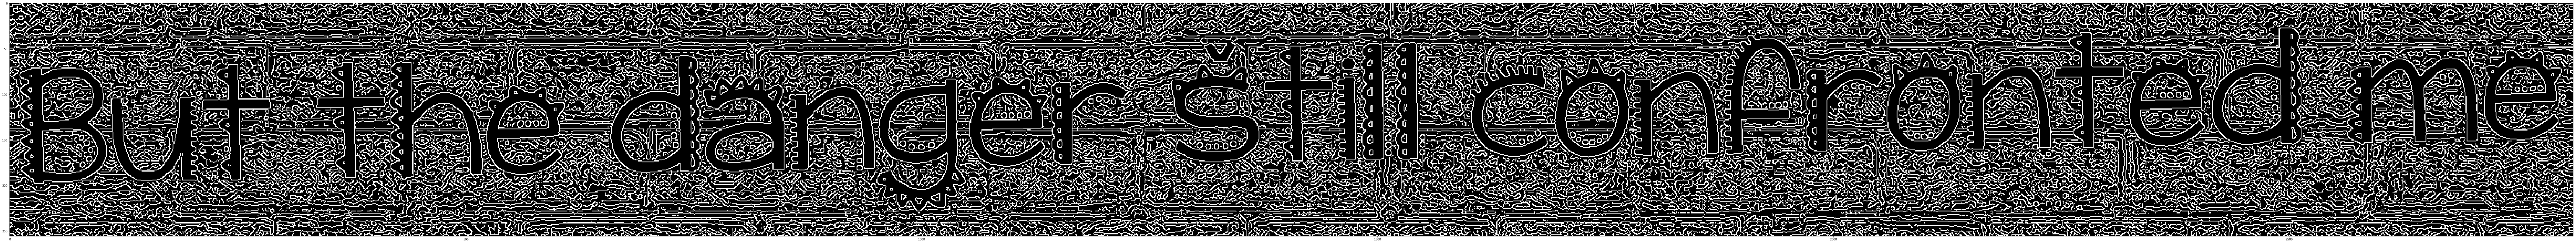

In [6]:
img = cv2.imread(image_path)
image = img.copy()
lab = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
a_component = lab[:,:,1]
edged = cv2.Canny(a_component, 10, 30)
plt.imshow(edged,'gray')


(256, 2812)


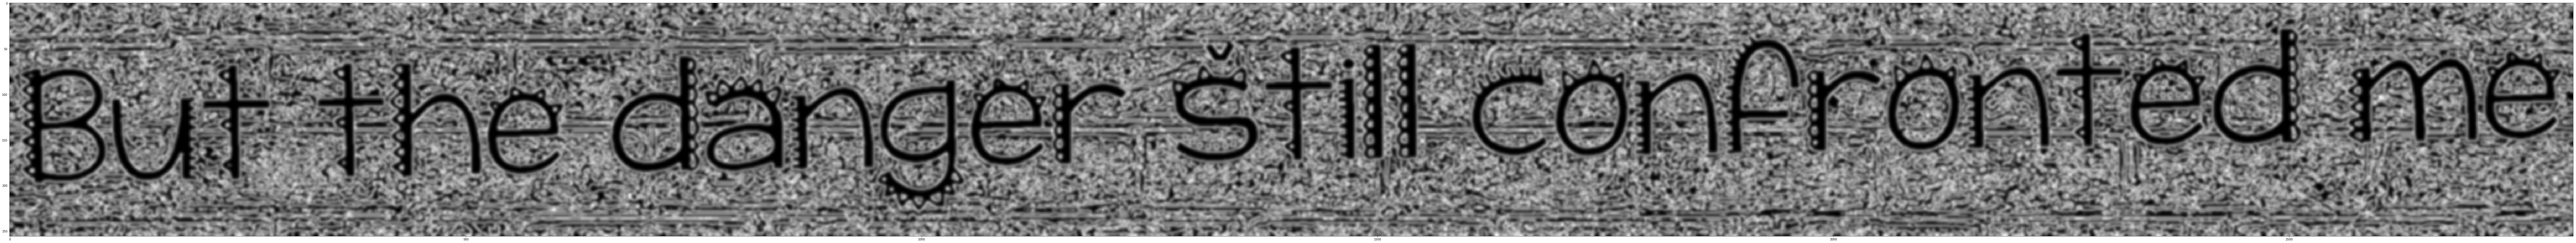

In [7]:
blur = cv2.GaussianBlur(edged,(9,9),0)
# blur = cv2.medianBlur(edged,1)
plt.imshow(blur,'gray')
print(blur.shape)

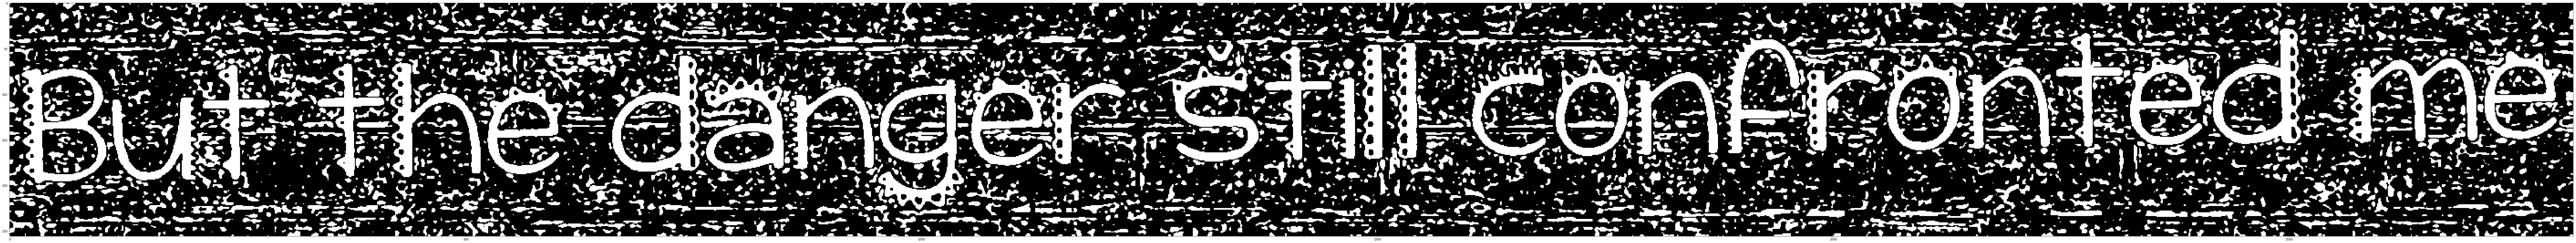

In [8]:
ret, image_bin = cv2.threshold(blur, 0, 255,cv2.THRESH_OTSU)
invertovana = invert(image_bin)
plt.imshow(invertovana,'gray')

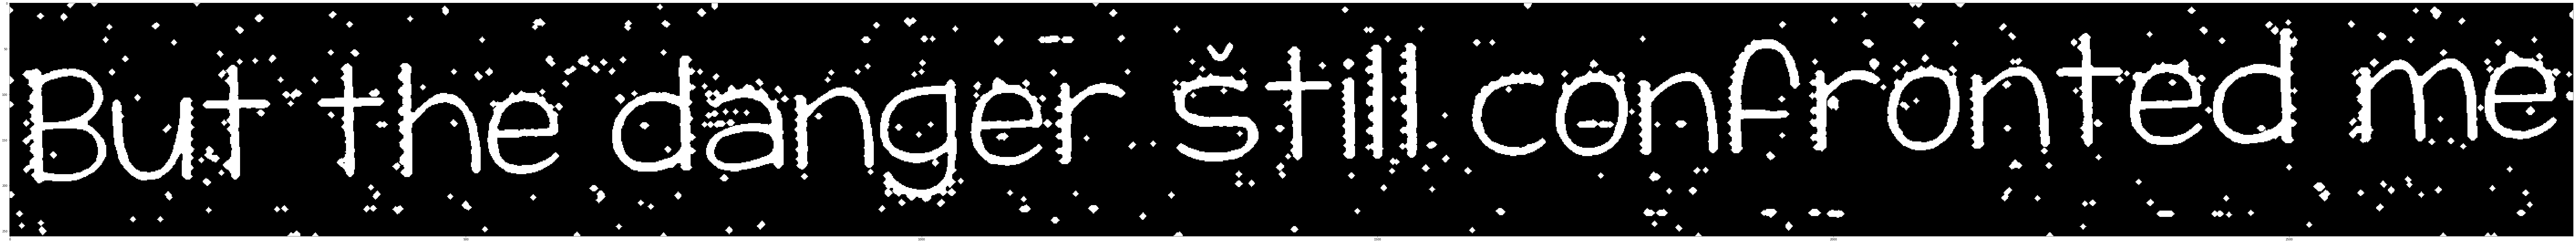

In [9]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
opening = cv2.morphologyEx(invertovana, cv2.MORPH_OPEN, kernel, iterations=3)
plt.imshow(opening,'gray')

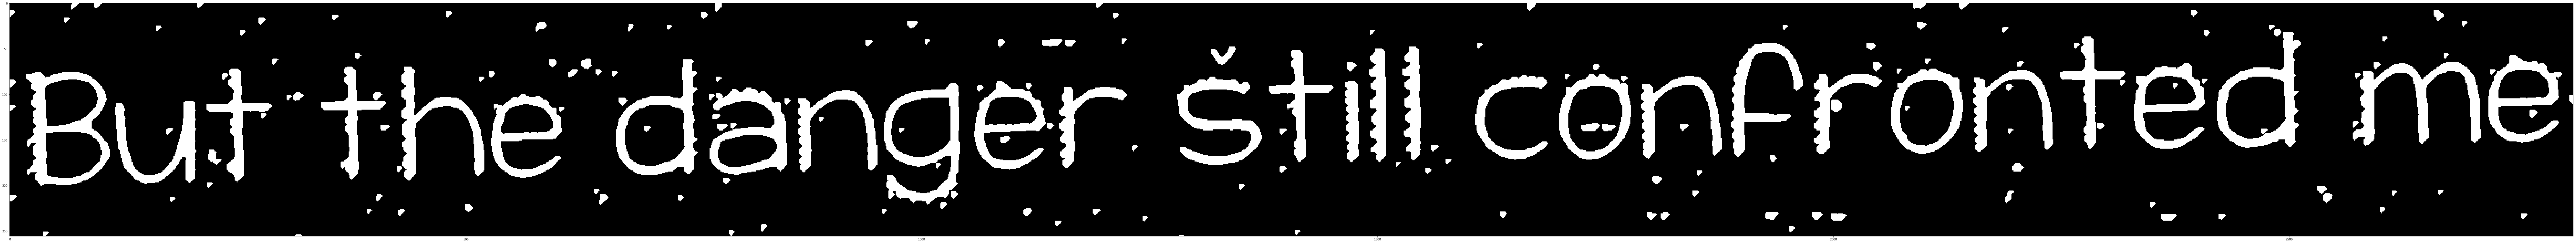

In [10]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
ero = cv2.morphologyEx(opening, cv2.MORPH_OPEN, kernel, iterations=4)
plt.imshow(ero,'gray')

In [ ]:

if percentWhitePixel > 20:
    image, img, opening = image_segmentation(image_path,0)
    img, opening = skew_correction(image, opening,0)
else:
    img, opening = skew_correction(image, opening,1)
plt.imshow(opening,'gray')
percentWhitePixel = get_percents_for_white_and_black_pixels(img, opening)

In [11]:
percentWhitePixel = get_percents_for_white_and_black_pixels(img, ero)

print("procenat belih: " + str(percentWhitePixel))

procenat belih: 11.004178520625889


In [ ]:
plt.rcParams['figure.figsize'] = 160, 141 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno

pronadjeno kontura: 180
meni koristnih: 29


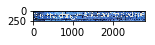

In [15]:
imga, contours, hierarchy = cv2.findContours(ero.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
image_crtanje = img.copy()
regions_array = []
print("pronadjeno kontura: " + str(len(contours)))
regija_kvacica = []

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
# TODO: PORAVNATI CELU SLIKU NEKAKO
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    k = y - 20
    if k < 1:
        k = y
    region = ero[y:y + h + 1, x:x + w + 1]
    povrsina = cv2.contourArea(contour)
    if (w < 5 + percentWhitePixel)  or (h < 25 + percentWhitePixel)  or (h + w) < 40:
#         print("w: " + str(w) + " h: " + str(h) + " size: " + str(h+w))
        if (h>20+percentWhitePixel and w < 10 + percentWhitePixel): # vrv je I u pitanju
            region = cv2.morphologyEx(region.copy(), cv2.MORPH_OPEN, kernel, iterations=1)
            regions_array.append([resize_region(region), (x, y, w, h)])
            continue
        else: # sum koji samo preskacemo
            continue
    # ZA SVAKI REGION RADIM POBOLJSANJE
    region = cv2.morphologyEx(region.copy(), cv2.MORPH_OPEN, kernel, iterations=1)
    # resize_region(region) or region
    regions_array.append([resize_region(region), (x, y, w, h)])
    
    
plt.imshow(image_crtanje)

regions_array = sorted(regions_array, key=lambda item: item[1][0])
sorted_regions = [region[0] for region in regions_array]
sorted_rectangles = [region[1] for region in regions_array]
    

region_distances = []
# Izdvojiti sortirane parametre opisujućih pravougaonika
# Izračunati rastojanja između svih susednih regiona po x osi i dodati ih u region_distances niz
for index in range(0, len(sorted_rectangles) - 1):    
    current = sorted_rectangles[index]
    next_rect = sorted_rectangles[index + 1]    
    distance = next_rect[0] - (current[0] + current[2])  # X_next - (X_current + W_current)
    region_distances.append(distance)


print("meni koristnih: " + str(len(sorted_regions)))


In [16]:
# PREDIKCIJA
print(extract_text(region_distances, sorted_regions, ann,vocabulary))

		 recenica: But the denYer Štiii cOnfrDnted me
		 procesirana recenica: But the danger štill confronted me

But the danger štill confronted me


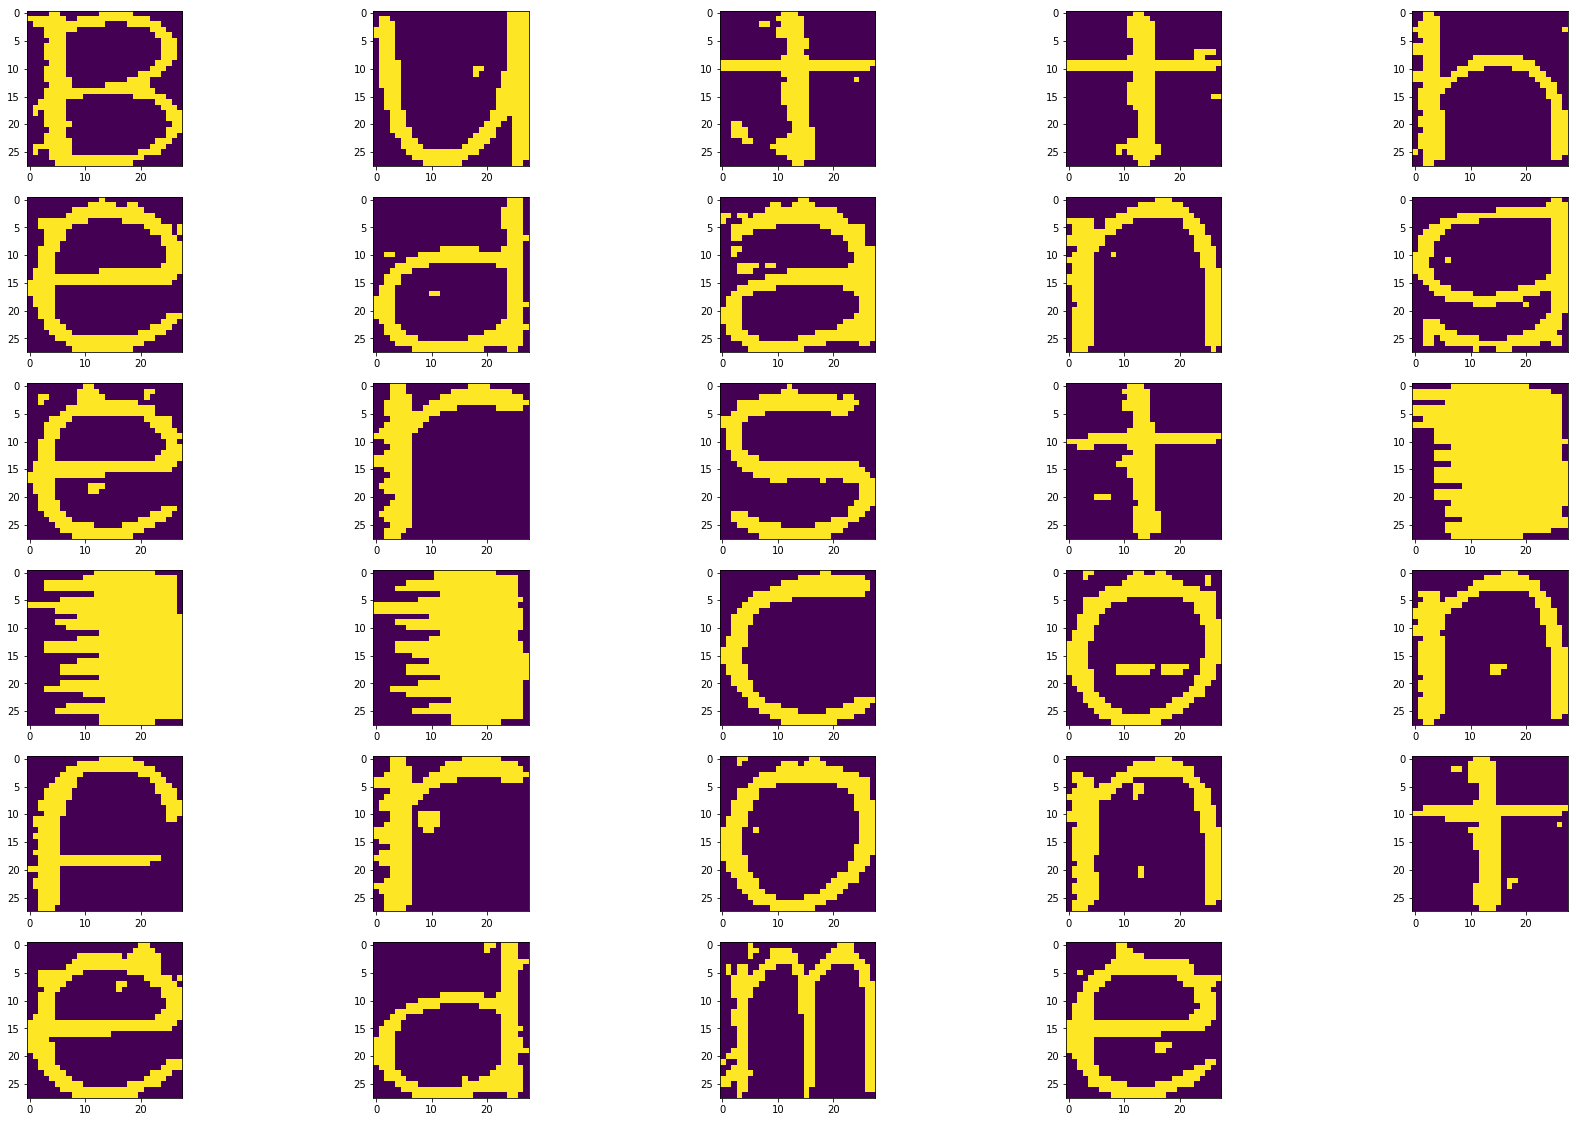

In [17]:
plt.rcParams['figure.figsize'] = 2, 2 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno
plot_images(sorted_regions)

In [ ]:
plt.imshow(sorted_regions[0])

In [ ]:
plt.imshow(sorted_regions[1])

In [ ]:
plt.imshow(sorted_regions[2])
print(sorted_rectangles[2])

In [ ]:
plt.imshow(sorted_regions[3])

In [ ]:
plt.imshow(sorted_regions[4])

In [ ]:
plt.imshow(sorted_regions[5])

In [ ]:
plt.imshow(sorted_regions[6])

In [ ]:
plt.imshow(sorted_regions[7])

In [ ]:
plt.imshow(sorted_regions[8])

In [ ]:
plt.imshow(sorted_regions[9])

In [ ]:
plt.imshow(sorted_regions[10])

In [ ]:
plt.imshow(sorted_regions[11])

In [ ]:
plt.imshow(sorted_regions[12])

In [ ]:
plt.imshow(sorted_regions[13])

In [ ]:
plt.imshow(sorted_regions[14])

In [ ]:
plt.imshow(sorted_regions[15])

In [ ]:
plt.imshow(sorted_regions[16])

In [ ]:
plt.imshow(sorted_regions[17])

In [ ]:
plt.imshow(sorted_regions[18])

In [ ]:
plt.imshow(sorted_regions[19])

In [ ]:
plt.imshow(sorted_regions[20])

In [ ]:
plt.imshow(sorted_regions[21])

In [ ]:
plt.imshow(sorted_regions[22])

In [ ]:
plt.imshow(sorted_regions[23])

In [ ]:
plt.imshow(sorted_regions[24])

In [ ]:
plt.imshow(sorted_regions[25])

In [ ]:
plt.imshow(sorted_regions[26])

In [ ]:
plt.imshow(sorted_regions[27])

In [ ]:
plt.imshow(sorted_regions[28])

In [ ]:
plt.imshow(sorted_regions[29])

In [ ]:
plt.imshow(sorted_regions[30])

In [ ]:
plt.imshow(sorted_regions[31])

In [ ]:
plt.imshow(sorted_regions[32])

In [ ]:
plt.imshow(sorted_regions[33])

In [ ]:
plt.imshow(sorted_regions[34])

In [ ]:
plt.imshow(sorted_regions[35])